# <div align="center">ĐỒ ÁN CUỐI KỲ NHẬP MÔN KHOA HỌC DỮ LIỆU</div>

### Thành viên nhóm:
* Dương Đoàn Bảo Sơn - 18120533
* Nguyễn Phạm Phúc Việt - 18129649
---
### <div align="center">Chủ đề: SỬ DỤNG MÔ HÌNH MACHINE LEARNING ĐỂ DỰ ĐOÁN THỜI TIẾT TRONG TƯƠNG LAI GẦN</div>

## I. Dữ liệu:
Dữ liệu được lấy từ cơ sở dữ liệu của Trung tâm Dự báo Môi trường Quốc gia Hoa Kỳ (NCEP) tại trang web [globalweather.tamu.edu](globalweather.tamu.edu). Dữ liệu được lấy tại trạm quan trắc khí tượng tại Đà Nẵng trong khoảng thời gian từ 1/1/1979 đến 	31/7/2014.
* [Link tải trực tiếp dữ liệu](https://globalweather.tamu.edu/data/cfsr/36316_2020-12-31-02-56-09.zip)

## II. Khám phá dữ liệu:
 #### 1. Import một số thư viện cần thiết

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

#### 2. Đọc dữ liệu và lưu vào dataframe

In [2]:
df = pd.read_csv('weatherdata-1611081.csv', index_col=False)
df

,Date,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1979,108.125,16.0798,21,21.789,20.032,8.433718,2.442694,0.945526,6.279357
1,1/2/1979,108.125,16.0798,21,22.050,19.974,1.917458,2.021508,0.923605,4.131790
2,1/3/1979,108.125,16.0798,21,22.847,19.485,0.520134,1.363726,0.865097,6.813003
3,1/4/1979,108.125,16.0798,21,22.304,18.682,0.224876,1.887963,0.862533,9.143603
4,1/5/1979,108.125,16.0798,21,23.549,19.568,0.509834,2.179407,0.865400,10.840449
...,...,...,...,...,...,...,...,...,...,...
12923,7/27/2014,108.125,16.0798,21,27.654,22.145,123.403941,0.722276,0.960563,11.988250
12924,7/28/2014,108.125,16.0798,21,27.882,22.253,38.002393,0.805266,0.950569,21.488302
12925,7/29/2014,108.125,16.0798,21,28.599,20.573,20.422551,0.824725,0.943231,9.977630
12926,7/30/2014,108.125,16.0798,21,27.441,21.986,24.712369,1.054239,0.960196,23.610801


#### 3. Ý nghĩa các cột: 

* Date: Ngày lấy dữ liệu
* Longitude, Latitude, Elevation: Kinh độ, vĩ độ, cao độ của điểm lấy dữ liệu (vì dữ liệu được lấy từ một trạm duy nhất nên các thông số này sẽ như nhau với tất cả các điểm dữ liệu)
* Max/Min Temperature (°C): Nhiệt độ cao nhất/thấp nhất trong ngày
* Precipitation (mm): Giáng thuỷ (Lượng nước từ mưa, mưa đá, tuyết; phân biệt với nước tách ra từ không khí như sương)
* Wind (m/s): Tốc độ gió trung bình trong ngày
* Relative Humidity (%): Độ ẩm tương đối
* Solar (MJ/m^2): Lượng bức xạ mặt trời trong ngày

#### 4. Kiểm tra mất mát dữ liệu

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12928 entries, 0 to 12927
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               12928 non-null  object 
 1   Longitude          12928 non-null  float64
 2   Latitude           12928 non-null  float64
 3   Elevation          12928 non-null  int64  
 4   Max Temperature    12928 non-null  float64
 5   Min Temperature    12928 non-null  float64
 6   Precipitation      12928 non-null  float64
 7   Wind               12928 non-null  float64
 8   Relative Humidity  12928 non-null  float64
 9   Solar              12928 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1010.1+ KB


=> tất cả các cột đều non-null, tức là không có ô nào bị thiếu

#### 5. Biểu diễn dữ liệu theo thời gian

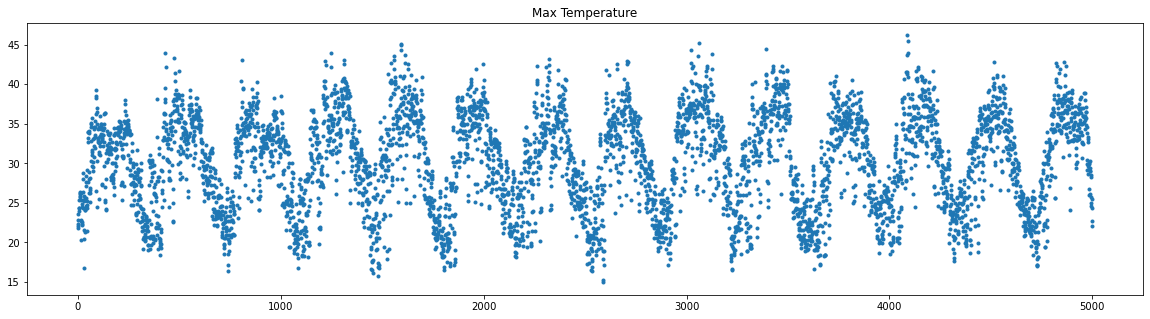

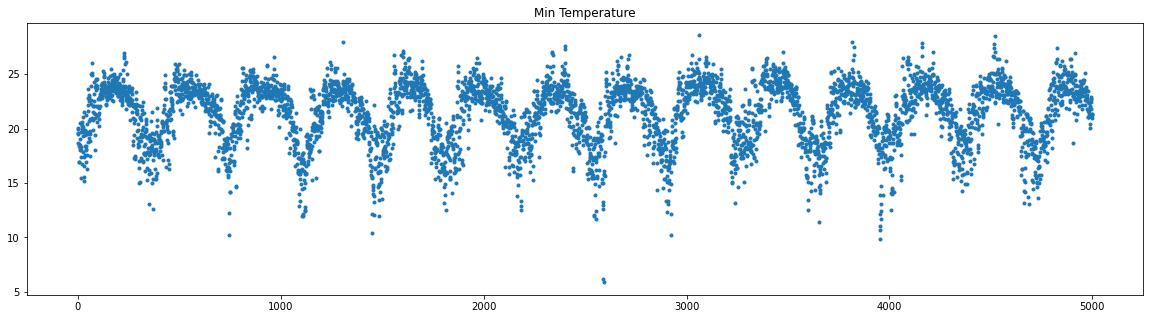

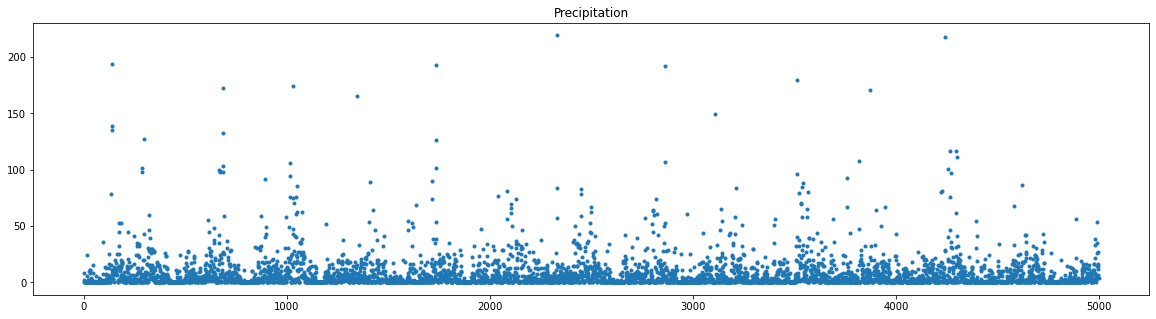

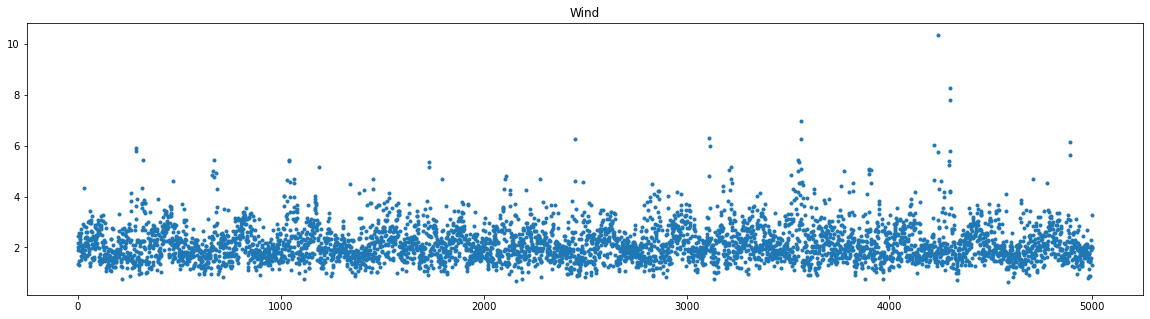

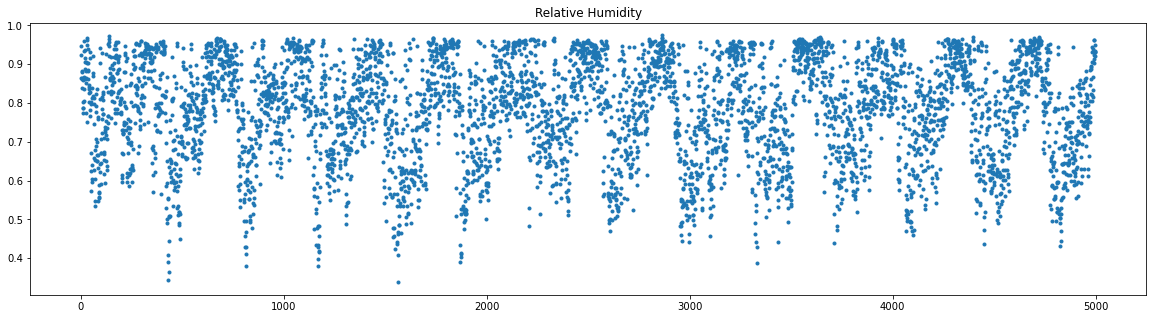

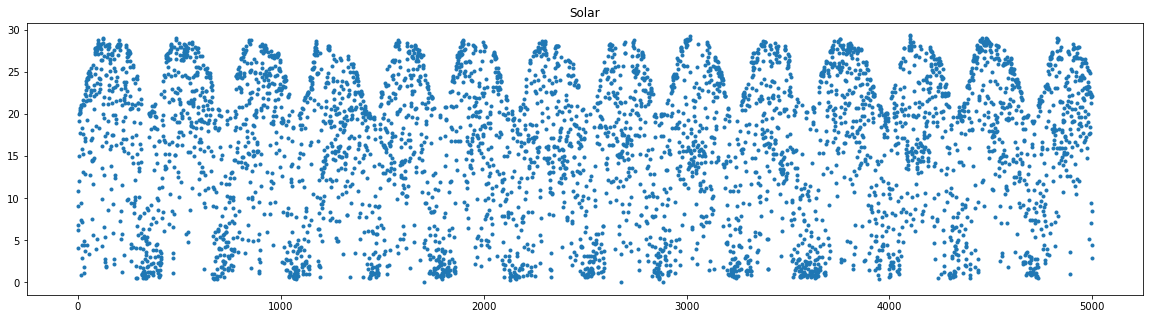

In [4]:
display_range = 5000
for col in [ 'Max Temperature', 'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity','Solar']:
    plt.figure(figsize=(20,5))
    plt.scatter(pd.RangeIndex(start=0, stop=display_range, step=1), df[col].head(display_range), marker = '.')
    plt.title(label=col)

## III. Tiền xử lý dữ liệu

**Vì mục đích cụ thể là dự đoán thời tiết (ở đây mình chọn dự đoán nhiệt độ trung bình) từ dữ liệu của n ngày trước đó (cụ thể là 3 ngày), nên có một số việc cần phải làm như sau:**
* Thêm cột 'Mean Temperature' vào bộ dữ liệu (cột này được tính từ 2 cột 'Max Temperature' và 'Min Temperature').
* Tạo bộ dữ liệu đầu vào, với mỗi dòng gồm dữ liệu thời tiết của 3 ngày trước ngày cần dự đoán.
* Drop một số cột không cần thiết

#### 1. Thêm cột Mean Temperature

In [5]:
mean_temp = (df['Max Temperature'] + df['Min Temperature'])/2
df.insert(loc=5, column='Mean Temperature', value=mean_temp)
df.head(5)

,Date,Longitude,Latitude,Elevation,Max Temperature,Mean Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1979,108.125,16.0798,21,21.789,20.9105,20.032,8.433718,2.442694,0.945526,6.279357
1,1/2/1979,108.125,16.0798,21,22.050,21.0120,19.974,1.917458,2.021508,0.923605,4.131790
2,1/3/1979,108.125,16.0798,21,22.847,21.1660,19.485,0.520134,1.363726,0.865097,6.813003
3,1/4/1979,108.125,16.0798,21,22.304,20.4930,18.682,0.224876,1.887963,0.862533,9.143603
4,1/5/1979,108.125,16.0798,21,23.549,21.5585,19.568,0.509834,2.179407,0.865400,10.840449


#### 2. Tạo bộ dữ liệu đầu vào, với mỗi dòng gồm dữ liệu thời tiết của 3 ngày trước ngày cần dự đoán. Đồng thời drop 1 số cột không cần thiết.

In [6]:
df.drop(['Longitude','Latitude','Elevation','Date'], axis=1, errors='ignore', inplace=True)

num_of_days = 3 # Số ngày dùng để predict output
def derive_nth_day_feature(df, feature, N):
        rows = df.shape[0]
        nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
        col_name = "{} {}".format(feature, N)
        df[col_name] = nth_prior_measurements
        
for feature in df.columns:
    if feature != 'Mean Temperature': 
        for N in range(1, num_of_days + 1):
            derive_nth_day_feature(df, feature, N)

df.drop(['Max Temperature', 'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity', 'Solar'], axis=1, errors='ignore', inplace=True)
            
df.fillna(method='bfill', inplace=True) # Điền các giá trị trống (3 ngày đầu tiên của bộ dữ liệu sẽ thiếu dữ liệu của các ngày trước đó)
df.head(5)

,Mean Temperature,Max Temperature 1,Max Temperature 2,Max Temperature 3,Min Temperature 1,Min Temperature 2,Min Temperature 3,Precipitation 1,Precipitation 2,Precipitation 3,Wind 1,Wind 2,Wind 3,Relative Humidity 1,Relative Humidity 2,Relative Humidity 3,Solar 1,Solar 2,Solar 3
0,20.9105,21.789,21.789,21.789,20.032,20.032,20.032,8.433718,8.433718,8.433718,2.442694,2.442694,2.442694,0.945526,0.945526,0.945526,6.279357,6.279357,6.279357
1,21.0120,21.789,21.789,21.789,20.032,20.032,20.032,8.433718,8.433718,8.433718,2.442694,2.442694,2.442694,0.945526,0.945526,0.945526,6.279357,6.279357,6.279357
2,21.1660,22.050,21.789,21.789,19.974,20.032,20.032,1.917458,8.433718,8.433718,2.021508,2.442694,2.442694,0.923605,0.945526,0.945526,4.131790,6.279357,6.279357
3,20.4930,22.847,22.050,21.789,19.485,19.974,20.032,0.520134,1.917458,8.433718,1.363726,2.021508,2.442694,0.865097,0.923605,0.945526,6.813003,4.131790,6.279357
4,21.5585,22.304,22.847,22.050,18.682,19.485,19.974,0.224876,0.520134,1.917458,1.887963,1.363726,2.021508,0.862533,0.865097,0.923605,9.143603,6.813003,4.131790


#### 3. Tách tập train, test theo tỉ lệ 80:20

In [7]:
y = df['Mean Temperature']
X = df[set(df.columns)-set(['Mean Temperature'])]

# Tách tập test và tập train theo tỉ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Sử dụng Linear Regression:

In [8]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("Model Score: " + str((regressor.score(X_test, y_test)*100).round(2)) + ' %')

Model Score: 87.51 %


---
# Using Neural Network:

In [9]:
display(X.head(5))
display(y.head(5))

,Precipitation 3,Max Temperature 3,Precipitation 1,Relative Humidity 2,Max Temperature 2,Max Temperature 1,Relative Humidity 1,Min Temperature 1,Solar 1,Solar 2,Min Temperature 3,Solar 3,Wind 1,Wind 2,Min Temperature 2,Relative Humidity 3,Wind 3,Precipitation 2
0,8.433718,21.789,8.433718,0.945526,21.789,21.789,0.945526,20.032,6.279357,6.279357,20.032,6.279357,2.442694,2.442694,20.032,0.945526,2.442694,8.433718
1,8.433718,21.789,8.433718,0.945526,21.789,21.789,0.945526,20.032,6.279357,6.279357,20.032,6.279357,2.442694,2.442694,20.032,0.945526,2.442694,8.433718
2,8.433718,21.789,1.917458,0.945526,21.789,22.050,0.923605,19.974,4.131790,6.279357,20.032,6.279357,2.021508,2.442694,20.032,0.945526,2.442694,8.433718
3,8.433718,21.789,0.520134,0.923605,22.050,22.847,0.865097,19.485,6.813003,4.131790,20.032,6.279357,1.363726,2.021508,19.974,0.945526,2.442694,1.917458
4,1.917458,22.050,0.224876,0.865097,22.847,22.304,0.862533,18.682,9.143603,6.813003,19.974,4.131790,1.887963,1.363726,19.485,0.923605,2.021508,0.520134


0    20.9105
1    21.0120
2    21.1660
3    20.4930
4    21.5585
Name: Mean Temperature, dtype: float64

In [10]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 75:25 (tương ứng train:val:test = 60:20:20)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [11]:
print(X_train_df.shape)
print(y_train_df.shape)

(7756, 18)
(7756,)


In [16]:
pipeline = make_pipeline(StandardScaler(),
                         MLPRegressor(hidden_layer_sizes=(10,10,10,10), activation='tanh', solver='adam', max_iter=5000))
train_errs = []
val_errs = []
alphas = [0.01, 0.15, 1, 3,5,6,10]
best_val_err = float('inf'); best_alpha = None;
                         
for alpha in alphas:
    pipeline.set_params(mlpregressor__alpha = alpha)
    pipeline.fit(X_train_df, y_train_df)
    pipeline.predict(X_val_df)
    train_err = (1 - pipeline.score(X_train_df, y_train_df))*100
    val_err = (1 - pipeline.score(X_val_df, y_val_df))*100
    if val_err < best_val_err:
        best_val_err = val_err
        best_alpha = alpha
    train_errs.append(train_err)
    val_errs.append(val_err)
'Done'

'Done'

## Trực quan hoá kết quả:

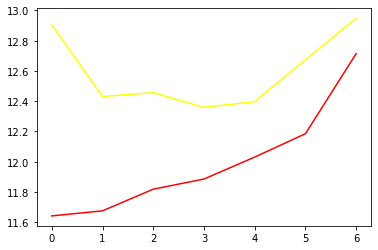

In [17]:
plt.plot(train_errs,color="red",)
plt.plot(val_errs,color="yellow")

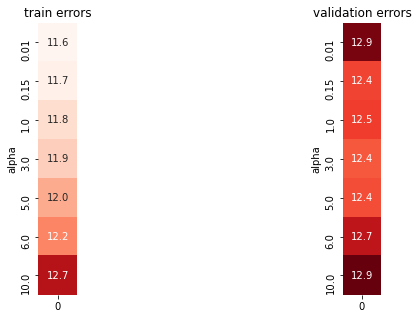

In [18]:
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.ylabel('alpha');

In [19]:
pipeline.set_params(mlpregressor__alpha = best_alpha)
pipeline.fit(X_train, y_train)
pipeline.predict(X_test)
print("Model Score: " + str((pipeline.score(X_test, y_test)*100).round(2)) + ' %')

Model Score: 88.47 %
